

# nnU-Net Training on BraTS2020 Dataset

This notebook demonstrates the full pipeline for brain tumor segmentation using nnU-Net on the BraTS2020 dataset.

**Pipeline Steps:**
- Preprocessing: co-registration, skull-stripping, FOV normalization, intensity normalization
- nnU-Net data preparation
- Training
- Validation & visualization
- Postprocessing

In [ ]:
from google.colab import files

# Upload your kaggle.json file
uploaded = files.upload()

Saving kaggle.json to kaggle.json


In [ ]:
# Install kaggle
!pip install kaggle

# Create kaggle directory
!mkdir ~/.kaggle

In [ ]:
# Move the API key to the right location
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
# Download the BraTS20 dataset
!kaggle datasets download -d awsaf49/brats20-dataset-training-validation

# Check the downloaded file
!ls -la

Dataset URL: https://www.kaggle.com/datasets/awsaf49/brats20-dataset-training-validation
License(s): CC0-1.0
 99% 4.14G/4.16G [00:56<00:00, 223MB/s]
100% 4.16G/4.16G [00:56<00:00, 78.6MB/s]
total 4363864
drwxr-xr-x 1 root root       4096 Jul 23 12:50 .
drwxr-xr-x 1 root root       4096 Jul 23 12:49 ..
-rw-r--r-- 1 root root 4468570941 Jul  2  2020 brats20-dataset-training-validation.zip
drwxr-xr-x 4 root root       4096 Jul 21 13:36 .config
-rw-r--r-- 1 root root         69 Jul 23 12:50 kaggle.json
drwxr-xr-x 1 root root       4096 Jul 21 13:37 sample_data


In [ ]:
# Unzip the dataset (this will take some time as it's a large dataset)
!unzip -q brats20-dataset-training-validation.zip

# Check the contents
!ls -la

total 4363872
drwxr-xr-x 1 root root       4096 Jul 23 13:00 .
drwxr-xr-x 1 root root       4096 Jul 23 12:49 ..
drwxr-xr-x 3 root root       4096 Jul 23 12:54 BraTS2020_TrainingData
drwxr-xr-x 3 root root       4096 Jul 23 13:00 BraTS2020_ValidationData
-rw-r--r-- 1 root root 4468570941 Jul  2  2020 brats20-dataset-training-validation.zip
drwxr-xr-x 4 root root       4096 Jul 21 13:36 .config
-rw-r--r-- 1 root root         69 Jul 23 12:50 kaggle.json
drwxr-xr-x 1 root root       4096 Jul 21 13:37 sample_data


In [ ]:
!df -h

Filesystem      Size  Used Avail Use% Mounted on
overlay         108G   83G   26G  77% /
tmpfs            64M     0   64M   0% /dev
shm             5.8G     0  5.8G   0% /dev/shm
/dev/root       2.0G  1.2G  775M  61% /usr/sbin/docker-init
tmpfs           6.4G  260K  6.4G   1% /var/colab
/dev/sda1       114G   84G   31G  73% /kaggle/input
tmpfs           6.4G     0  6.4G   0% /proc/acpi
tmpfs           6.4G     0  6.4G   0% /proc/scsi
tmpfs           6.4G     0  6.4G   0% /sys/firmware


In [ ]:
import nibabel as nib

nii_path = "/content/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_001/BraTS20_Training_001_flair.nii"
img = nib.load(nii_path)
print("Shape:", img.shape)

Shape: (240, 240, 155)


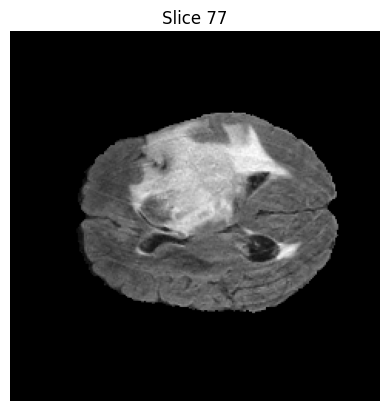

In [ ]:
img_data = img.get_fdata()
slice_index = img_data.shape[2] // 2

import matplotlib.pyplot as plt
plt.imshow(img_data[:, :, slice_index], cmap='gray')
plt.title(f'Slice {slice_index}')
plt.axis('off')
plt.show()

✅ Loaded image shape: (240, 240, 155)
✅ Loaded segmentation shape: (240, 240, 155)


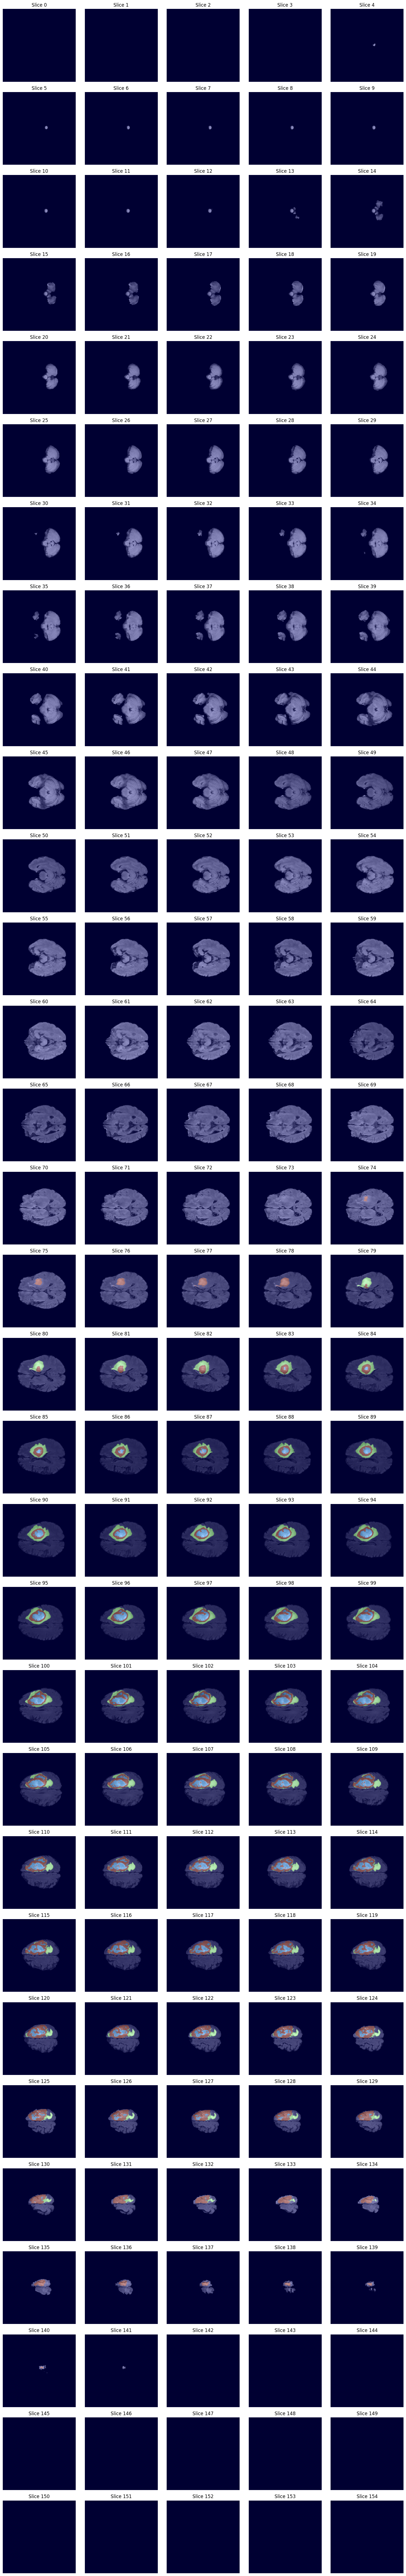

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import nibabel as nib  # For loading .nii/.nii.gz files

# ==== Load 3D Images (Original + Segmentation) ====
# Replace these paths with your actual files
image_path = "/content/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_355/BraTS20_Training_355_flair.nii"
seg_path = "/content/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_355/W39_1998.09.19_Segm.nii"

# Load the volumes
img = nib.load(image_path)
seg = nib.load(seg_path)

img_data = img.get_fdata()
seg_data = seg.get_fdata()

print(f"✅ Loaded image shape: {img_data.shape}")
print(f"✅ Loaded segmentation shape: {seg_data.shape}")

# ==== Display all slices ====
num_slices = img_data.shape[2]
cols = 5
rows = int(np.ceil(num_slices / cols))

plt.figure(figsize=(15, 3 * rows))

for i in range(num_slices):
    plt.subplot(rows, cols, i + 1)
    plt.imshow(img_data[:, :, i], cmap='gray')
    plt.imshow(seg_data[:, :, i], cmap='jet', alpha=0.4)  # overlay
    plt.title(f"Slice {i}")
    plt.axis('off')

plt.tight_layout()
plt.show()


Image shape: (240, 240, 155)


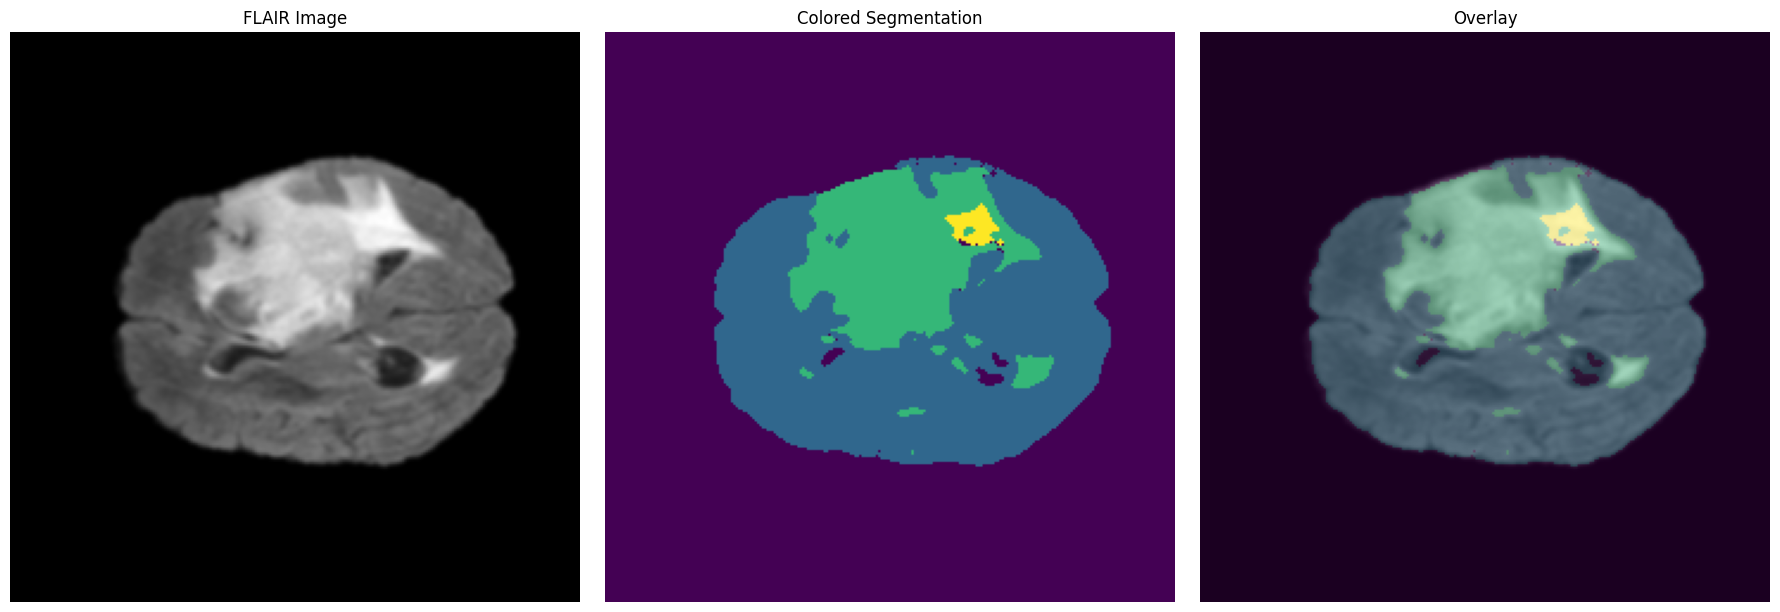


Segmentation Breakdown:
Background: 7605031 voxels
Class 1: 972244 voxels
Class 2: 340222 voxels
Class 3: 10503 voxels


In [ ]:
import numpy as np
import nibabel as nib
import matplotlib.pyplot as plt
from skimage import filters, morphology

# Load real FLAIR image
nii_path = "/content/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_001/BraTS20_Training_001_flair.nii"
img = nib.load(nii_path)
img_data = img.get_fdata()
print("Image shape:", img_data.shape)

# Normalize image
img_data = (img_data - np.min(img_data)) / (np.max(img_data) - np.min(img_data))

# Apply Gaussian smoothing
smoothed = filters.gaussian(img_data, sigma=1.0)

# Multi-class segmentation based on intensity ranges (very simple mock-up)
seg_map = np.zeros_like(smoothed, dtype=np.uint8)
seg_map[(smoothed >= 0.1) & (smoothed < 0.3)] = 1  # Class 1
seg_map[(smoothed >= 0.3) & (smoothed < 0.6)] = 2  # Class 2
seg_map[smoothed >= 0.6] = 3                      # Class 3

# Post-process each class
for cls in [1, 2, 3]:
    mask = (seg_map == cls)
    mask = morphology.binary_opening(mask)
    mask = morphology.binary_closing(mask)
    seg_map[seg_map == cls] = 0
    seg_map[mask] = cls

# Pick middle slice
slice_idx = img_data.shape[2] // 2

# Plot results
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Original FLAIR
axes[0].imshow(smoothed[:, :, slice_idx], cmap='gray')
axes[0].set_title("FLAIR Image")
axes[0].axis("off")

# Segmentation (colored)
axes[1].imshow(seg_map[:, :, slice_idx], cmap='viridis')
axes[1].set_title("Colored Segmentation")
axes[1].axis("off")

# Overlay
axes[2].imshow(smoothed[:, :, slice_idx], cmap='gray')
axes[2].imshow(seg_map[:, :, slice_idx], cmap='viridis', alpha=0.4)
axes[2].set_title("Overlay")
axes[2].axis("off")

plt.tight_layout()
plt.show()

# Optional: Show voxel counts
unique_labels, counts = np.unique(seg_map, return_counts=True)
label_names = ["Background", "Class 1", "Class 2", "Class 3"]
print("\nSegmentation Breakdown:")
for label, count in zip(unique_labels, counts):
    name = label_names[label] if label < len(label_names) else f"Class {label}"
    print(f"{name}: {count} voxels")


In [ ]:
# Install SimpleITK
!pip install SimpleITK

# Install ANTs
!pip install antspyx

# Install other common medical imaging libraries
!pip install nibabel
!pip install pydicom
!pip install scikit-image

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.6/52.6 MB 7.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.4/22.4 MB 69.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 37.7/37.7 MB 12.4 MB/s eta 0:00:00
  Attempting uninstall: scipy
    Found existing installation: scipy 1.16.0
    Uninstalling scipy-1.16.0:
      Successfully uninstalled scipy-1.16.0


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 21.4 MB/s eta 0:00:00


In [ ]:
!pip install nnunet


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 276.6/276.6 kB 4.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 156.3/156.3 kB 8.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.0/77.0 kB 5.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 80.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 63.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 37.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 14.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.9 MB/s eta 0:00:

In [ ]:
# Working Medical Image Analysis Imports
# Fixed imports based on your actual nnU-Net installation

import os
import numpy as np
import matplotlib.pyplot as plt
import SimpleITK as sitk
import ants
import subprocess
from nnunet.inference.predict import predict_from_folder
import shutil
import glob
import json
from tqdm import tqdm

# Optional: Suppress warnings for cleaner output
import warnings
warnings.filterwarnings('ignore')

# Import nnU-Net paths safely - only what's available
try:
    from nnunet.paths import nnUNet_raw_data
    print("✅ nnUNet_raw_data imported successfully")
except ImportError:
    print("⚠️  nnUNet_raw_data not available, using environment variables")
    nnUNet_raw_data = os.environ.get('nnUNet_raw_data_base', '/content/nnunet_data/nnUNet_raw_data_base')

# Use environment variables for paths that might not be importable
nnUNet_preprocessed = os.environ.get('nnUNet_preprocessed', '/content/nnunet_data/nnUNet_preprocessed')
nnUNet_results = os.environ.get('RESULTS_FOLDER', '/content/nnunet_data/nnUNet_results')

print("✅ All imports successful!")
print("🧠 Ready for medical image analysis with:")
print("   • SimpleITK - Medical image I/O and basic processing")
print("   • ANTs - Advanced normalization and registration")
print("   • nnU-Net - Deep learning segmentation")
print("   • NumPy/Matplotlib - Numerical computing and visualization")
print(f"📁 nnU-Net paths configured:")
print(f"   Raw data: {nnUNet_raw_data}")
print(f"   Preprocessed: {nnUNet_preprocessed}")
print(f"   Results: {nnUNet_results}")

ModuleNotFoundError: No module named 'SimpleITK'

## 1. Set Paths

Define the paths to your data and output directories. Adjust as needed.

In [ ]:
# Paths (edit as needed)
TRAIN_DIR = 'BraTS2020_ValidationData/MICCAI_BraTS2020_ValidationData'
VAL_DIR = 'BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData'
NNUNET_DATA = './nnunet_data/Task999_BraTS2020'
os.makedirs(NNUNET_DATA, exist_ok=True)

IMAGES_TR = os.path.join(NNUNET_DATA, 'imagesTr')
LABELS_TR = os.path.join(NNUNET_DATA, 'labelsTr')
IMAGES_VAL = os.path.join(NNUNET_DATA, 'imagesTs')
os.makedirs(IMAGES_TR, exist_ok=True)
os.makedirs(LABELS_TR, exist_ok=True)
os.makedirs(IMAGES_VAL, exist_ok=True)

### 2.1 Co-registration (ANTsPy)

Align all modalities for each subject using ANTsPy.

In [ ]:
def coregister_modalities(modality_files):
    # Use the first modality as reference
    ref_img = ants.image_read(modality_files[0])
    registered = [ref_img]
    for f in modality_files[1:]:
        moving = ants.image_read(f)
        tx = ants.registration(fixed=ref_img, moving=moving, type_of_transform='Affine')
        registered.append(tx['warpedmovout'])
    return registered

### 2.2 Skull-stripping (FSL BET)

Remove non-brain tissue from each scan using FSL BET.

In [ ]:
def skull_strip_fsl(input_nii, output_nii, frac=0.5):
    """
    Skull-strip a NIfTI image using FSL BET.
    Args:
        input_nii (str): Path to input NIfTI file.
        output_nii (str): Path to output skull-stripped NIfTI file.
        frac (float): Fractional intensity threshold (0->1); smaller values give larger brain outline estimates.
    """
    command = f"bet {input_nii} {output_nii} -f {frac} -g 0 -m"
    result = subprocess.run(command, shell=True, capture_output=True)
    if result.returncode != 0:
        print('FSL BET failed:', result.stderr.decode())
    else:
        print('FSL BET completed:', output_nii)

### 2.3 FOV Normalization

Crop and pad images to center the brain region.

In [ ]:
def crop_to_brain(img, mask):
    arr = sitk.GetArrayFromImage(mask)
    coords = np.array(np.where(arr > 0))
    minc, maxc = coords.min(axis=1), coords.max(axis=1)
    cropped = img[minc[0]:maxc[0]+1, minc[1]:maxc[1]+1, minc[2]:maxc[2]+1]
    return cropped

### 2.4 Intensity Normalization

Z-score normalization per modality per scan.

In [ ]:
def zscore_normalize(img):
    arr = sitk.GetArrayFromImage(img)
    arr = (arr - arr.mean()) / arr.std()
    return sitk.GetImageFromArray(arr)

## 3. Prepare nnU-Net Data Structure

Convert preprocessed images and labels to nnU-Net format.


In [ ]:
# Example: Save preprocessed images in nnU-Net format
def save_nnunet_format(imgs, label, case_id, out_img_dir, out_lbl_dir):
    for i, img in enumerate(imgs):
        sitk.WriteImage(img, os.path.join(out_img_dir, f'{case_id}_000{i}.nii.gz'))
    sitk.WriteImage(label, os.path.join(out_lbl_dir, f'{case_id}.nii.gz'))

In [ ]:
  !pip install nibabel

In [ ]:
    import os
    print(os.listdir('/content'))

In [ ]:
import os
import shutil

brats_root = '/content/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData'
nnunet_imagesTr = '/content/nnunet_data/Dataset999_BraTS2020/imagesTr'
nnunet_labelsTr = '/content/nnunet_data/Dataset999_BraTS2020/labelsTr'

os.makedirs(nnunet_imagesTr, exist_ok=True)
os.makedirs(nnunet_labelsTr, exist_ok=True)

modalities = {
    't1': 0,
    't1ce': 1,
    't2': 2,
    'flair': 3
}

subjects = sorted(os.listdir(brats_root))
for idx, subj in enumerate(subjects):
    subj_path = os.path.join(brats_root, subj)
    if not os.path.isdir(subj_path):
        continue
    case_id = f"case_{idx:05d}"
    files = {f.lower(): f for f in os.listdir(subj_path)}
    for mod, mod_idx in modalities.items():
        name = f"{subj}_{mod}.nii"
        if name.lower() in files:
            src = os.path.join(subj_path, files[name.lower()])
            dst = os.path.join(nnunet_imagesTr, f"{case_id}_{mod_idx:04d}.nii.gz")
            # Convert .nii to .nii.gz for nnU-Net
            import nibabel as nib
            img = nib.load(src)
            nib.save(img, dst)
        else:
            print(f"WARNING: {mod} modality not found for {subj}")
    # Copy label
    label_name = f"{subj}_seg.nii"
    if label_name.lower() in files:
        label_src = os.path.join(subj_path, files[label_name.lower()])
        label_dst = os.path.join(nnunet_labelsTr, f"{case_id}.nii.gz")
        img = nib.load(label_src)
        nib.save(img, label_dst)
    else:
        print(f"WARNING: Segmentation label not found for {subj}")

## 4. nnU-Net Dataset JSON

Create a dataset.json file for nnU-Net.


In [ ]:

import os
import json

base = '/content/nnunet_data/Dataset999_BraTS2020'
imagesTr = sorted([f for f in os.listdir(os.path.join(base, 'imagesTr')) if f.endswith('.nii.gz')])
labelsTr = sorted([f for f in os.listdir(os.path.join(base, 'labelsTr')) if f.endswith('.nii.gz')])
imagesTs = sorted([f for f in os.listdir(os.path.join(base, 'imagesTs')) if f.endswith('.nii.gz')])

training = []
for img in imagesTr:
    # img: 'case_00000_0000.nii.gz'
    case_id = '_'.join(img.split('_')[:2])  # 'case_00000'
    label = f"{case_id}.nii.gz"
    if label in labelsTr:
        training.append({"image": f"imagesTr/{img}", "label": f"labelsTr/{label}"})
test = [f"imagesTs/{img}" for img in imagesTs]

dataset_json = {
    "name": "BraTS2020",
    "description": "BraTS2020 brain tumor segmentation",
    "tensorImageSize": "4D",
    "reference": "",
    "licence": "",
    "release": "1.0",
    "modality": {
        "0": "T1",
        "1": "T1c",
        "2": "T2",
        "3": "FLAIR"
    },
    "labels": {
        "0": "background",
        "1": "edema",
        "2": "non-enhancing tumor",
        "3": "enhancing tumor"
    },
    "file_ending": ".nii.gz",
    "numTraining": len(training),
    "numTest": len(test),
    "training": training,
    "test": test
}

with open(os.path.join(base, 'dataset.json'), 'w') as f:
    json.dump(dataset_json, f, indent=4)

print(f"numTraining: {len(training)}, numTest: {len(test)}")

## 5. nnU-Net Training

Train the nnU-Net model on the prepared dataset.




In [ ]:
import os

os.environ['nnUNet_raw'] = '/content/nnunet_data'
os.environ['nnUNet_preprocessed'] = '/content/nnunet_data/nnUNet_preprocessed'
os.environ['nnUNet_results'] = '/content/nnunet_data/nnUNet_results'

In [ ]:
with open('/content/nnunet_data/Dataset999_BraTS2020/dataset.json') as f:
    print(f.read())

In [ ]:
!ls /content/nnunet_data/Dataset999_BraTS2020

In [ ]:
# Set nnU-Net environment variables
os.environ['nnUNet_raw_data_base'] = os.path.abspath('./nnunet_data')
os.environ['nnUNet_preprocessed'] = os.path.abspath('./nnunet_preprocessed')
os.environ['nnUNet_results'] = os.path.abspath('./nnunet_results')

# Train (example for nnU-Net v2 CLI, adjust for v1 if needed)
!nnUNetv2_train --config 3d_fullres --d 999 --fold 0 --gpu 0